# Stock trading strategy
### Author: Hoang Van Phan

In this notebook, I develop and improve a trading strategy that only relies on the trend of a stock's daily open price. This is a very simplified simulation of stock trading. First, it is assumed that the bid price is equal to the ask price. Second, any price intra-day variation is disregarded. Third, the money obtained from selling shares is assumed to be immediately available for use. Fourth, the stock price is completely unaffected by my buying or selling shares.

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import yfinance as yf # for downloading stock price from Yahoo Finance
import scipy.signal as signal
from datetime import datetime

# Save a list of nice looking colors
my_colors = plt.get_cmap('tab10')

# Timestamp
print(f"========== Notebook executed on {datetime.now().replace(microsecond=0)} ==========")

========== Notebook executed on 2020-08-10 19:58:20 ==========


## Import a stock price history

Stock price is imported from Yahoo Finance using yfinance package. Amazon's stock price is used for testing in the beginning. I will only look at stock price after 2010.

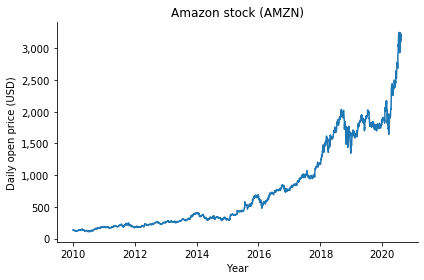

In [2]:
# Pick Amazon's stock
amzn = yf.Ticker("AMZN")
amzn_price = amzn.history(start="2010-01-01")

# Plot
fig, ax = plt.subplots(tight_layout=True)
ax.plot(amzn_price["Open"])
ax.set_xlabel("Year")
ax.set_ylabel("Daily open price (USD)")
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title("Amazon stock (AMZN)")
sns.despine(fig=fig)

## Trading strategy 1

Trading strategy 1 is simple: if stock price of a company has risen for x days (excluding weekends) consecutively after a local minimum, buy **one** share, and if stock price has fallen for x days consecutively after a local maximum, sell **all** shares.

The argument for this trading strategy is the assumption that a local minimum represents a drop in stock price, and a sustained increase after that local minimum signals that the stock price is recovering, and thus is a good time for buying. Conversely, a local maximum represents a peak in stock price, and a sustained decrease signals that the stock price is not increasing anymore, and therefore is a good time for selling.

The intended profit earning method for this strategy is through captain gains that come from selling shares at a profit.

First, I implement the trading strategy as function trading_start1(). The function will return the date and action of all taken transactions.

In [3]:
def trading_strat1(price, min_x=1, max_x=5, fees=0, budget=None):
    '''
    This function will implement trading strategy 1.
    
    A share is bought when stock price has increased consecutively for x days after the last local minimum.
    
    All currently owned shares are sold when stock price has decreased consecutively for x days after the last local maximum.
    
    Input:
    ----------
    price: numpy array
        An 1D numpy array containing the daily stock price.
    min_x: int
        The minimum number of days to test the trading strategy.
        Default is 1.
    max_x: int
        The maximum number of days to test the trading strategy.
        Default is 5.
    fees: float
        The brokerage fees per transaction.
        Default is 0.
    budget: int or None
        The budget of the trader. If int, then the trade can only buy stocks if he has enough money left. If None, assume
        the trader has infinite amount of money.
        Default is None.
        
    Output:
    ----------
    A dictionary of transaction history
    The keys indicate value of x.
    The values are numpy arrays of shape (number of transactions, 2)
    First column is the index of price array at which a transaction occurs
    Second column indicates whether the transaction is buying (denoted by +1, ie buying one share) or selling (denoted by -n,
    ie, selling all n shares)
    '''
    
    if budget is None:
        budget = np.inf
    
    out_dict = {}
    
    # Find indices of all local minima and maxima
    minima = signal.argrelmin(price)[0]
    maxima = signal.argrelmax(price)[0]
    
    # Combine the indices and sort
    # The local minima and maxima will be alternating
    combine = np.sort(np.hstack([minima, maxima]))
    
    # Find the gap between a pair of adjacent minimum and maximum
    combine_gap = np.diff(combine)
    
    # Convert the minima and maxima arrays into sets for faster 'in' operator later on
    minima = set(minima)
    maxima = set(maxima)
    
    # Loop through each value of x to be tested
    for x in range(min_x, max_x+1):
        temp_budget = budget # reset the current budget
        n_shares = 0 # track the number of shares currently own
        trade_index = [] # track the index when transaction occurs
        trade_info = [] # track the number of shares bought or sold
        
        # Go through gaps that are at least x-days long
        for i in combine[np.where(combine_gap >= x)]:                
            # Buy decision, check if have enough money left
            if (i in minima) and (temp_budget >= price[i+x] - fees):
                temp_budget = temp_budget - price[i+x] - fees
                trade_index.append(i+x)
                trade_info.append(1)
                n_shares += 1
                
            # Sell decision
            elif (i in maxima) and (n_shares > 0):
                temp_budget = temp_budget + price[i+x]*n_shares - fees
                trade_index.append(i+x)
                trade_info.append(-n_shares)
                n_shares = 0

        # Update dictionary
        out_dict[x] = np.array([trade_index, trade_info]).T
        
    return out_dict

Let us visualize the transaction history of the past 1 year for x = 3 days, when I have an unlimited budget (ie, I can buy as many shares as I want without budget constraint).

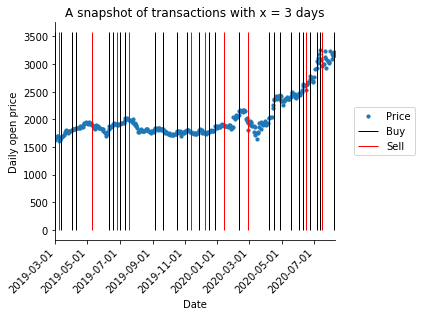

In [4]:
# Convert stock price and date to numpy arrays
amzn_price_np = amzn_price["Open"].to_numpy()
amzn_date = amzn_price.index.to_numpy()

# Implement trading strategy
amzn_dict = trading_strat1(amzn_price_np, min_x=3)

# Visualize trading patterns to confirm trading_simple() works as expected
fig, ax = plt.subplots(figsize=(6,4.5), tight_layout=True)
ax.scatter(amzn_date, amzn_price_np, s=10, label="Price")
ax.vlines(amzn_date[amzn_dict[3][amzn_dict[3][:,1]>0,0]], 0, amzn_price_np.max()*1.1, lw=1, label="Buy")
ax.vlines(amzn_date[amzn_dict[3][amzn_dict[3][:,1]<0,0]], 0, amzn_price_np.max()*1.1, lw=1, color='red', label="Sell")
ax.set_xlim(amzn_date[-365],amzn_date[-1])
# ax.set_ylim(200,450)
ax.set_xticklabels([datetime.fromordinal(int(s)).date() for s in ax.get_xticks()], rotation=45, ha='right')
ax.set_xlabel("Date")
ax.set_ylabel("Daily open price")
ax.legend(bbox_to_anchor=(1.05,0.5), loc="center left")
ax.set_title("A snapshot of transactions with x = 3 days")
sns.despine(fig=fig)

Now, to check how effective the trading strategy is, I will look at three numbers:
* Earning: how much money I earn from selling shares, minus how much money I spend on buying shares.
* Share worth: how much the shares I still own at the end of the period are worth.
* Profit (most important): equal earning plus share worth, ie, profit is calculated assuming all shares are sold at the current price.

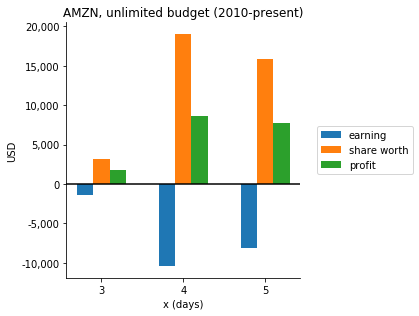

In [5]:
bar_width = 0.2
fig, ax = plt.subplots(figsize=(6,4.5), tight_layout=True)
for key, value in amzn_dict.items():
    # Plot earning
    earning = -np.sum(amzn_price_np[value[:,0]]*value[:,1])
    bar1 = ax.bar(key-bar_width, earning, width=bar_width, color=my_colors(0))
    
    # Plot share worth
    share_worth = np.sum(value[:,1])*amzn_price_np[-1]
    bar2 = ax.bar(key, share_worth, width=bar_width, color=my_colors(1))
    
    # Plot profit
    bar3 = ax.bar(key+bar_width, earning+share_worth, width=bar_width, color=my_colors(2))
ax.axhline(0,color='black')
ax.set_xticks(list(amzn_dict.keys()))
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel("x (days)")
ax.set_ylabel("USD")
ax.set_title("AMZN, unlimited budget (2010-present)")
ax.legend([bar1, bar2, bar3], ["earning","share worth","profit"], bbox_to_anchor=(1.05,0.5), loc="center left")
sns.despine(fig=fig)

It is suspicious that the profit for x = 3 days is so low compared to x = 4 or 5 days. Let us look at the trading activities during the last 120 days.

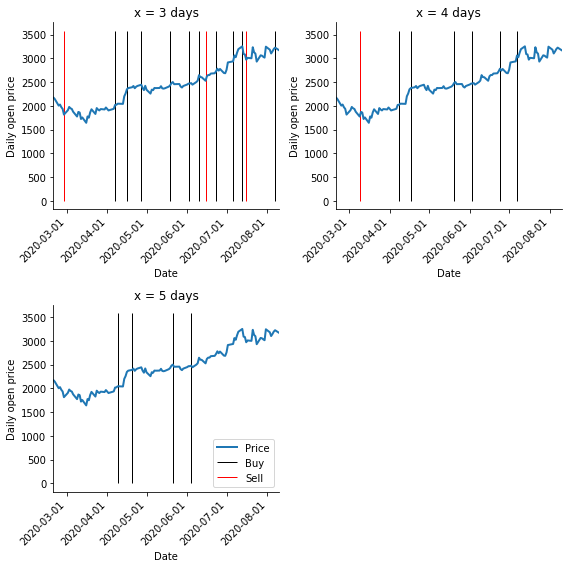

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8), tight_layout=True)
for counter, key in enumerate(amzn_dict.keys()):
    irow = int(counter/2)
    icol = int(counter % 2)
    ax[irow, icol].plot(amzn_date, amzn_price_np, lw=2, label="Price")
    ax[irow, icol].vlines(amzn_date[amzn_dict[key][amzn_dict[key][:,1]>0,0]],
                          0, amzn_price_np.max()*1.1, lw=1, label="Buy")
    ax[irow, icol].vlines(amzn_date[amzn_dict[key][amzn_dict[key][:,1]<0,0]],
                          0, amzn_price_np.max()*1.1, lw=1, color='red', label="Sell")
    ax[irow, icol].set_title(f"x = {key} days")
    ax[irow, icol].set_xlim(amzn_date[-120],amzn_date[-1])
    ax[irow, icol].set_xticklabels([datetime.fromordinal(int(s)).date() for s in ax[irow, icol].get_xticks()],
                                   rotation=45, ha='right')
    ax[irow, icol].set_xlabel("Date")
    ax[irow, icol].set_ylabel("Daily open price")
ax[1,0].legend(loc="lower right")
fig.delaxes(ax[1,1])
sns.despine(fig=fig)

It seems that the profit of x = 3 days is low because the stock price is too volatile for a 3-day window, so that sometimes the share price is sold too fast, missing out on higher profit. One the other hands, because AMZN stock price at the moment is very high, the share worth of x = 4 and 5 days is so high that the profit becomes much higher than that of x = 3 days.

Let us now impose a budget of \\$10,000 and test the strategy again.

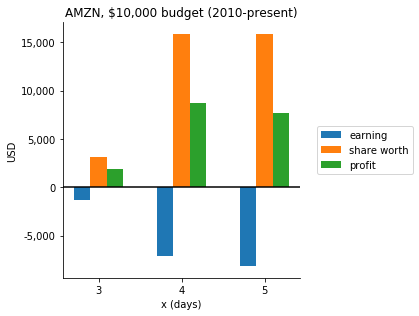

In [7]:
# Check for x = 3, 4, 5 days with a $10,000 budget
amzn_dict_10k = trading_strat1(amzn_price_np, min_x=3, max_x=5, budget=10_000)

bar_width = 0.2
fig, ax = plt.subplots(figsize=(6,4.5), tight_layout=True)
for key, value in amzn_dict_10k.items():
    # Plot earning
    earning = -np.sum(amzn_price_np[value[:,0]]*value[:,1])
    bar1 = ax.bar(key-bar_width, earning, width=bar_width, color=my_colors(0))
    
    # Plot share worth
    share_worth = np.sum(value[:,1])*amzn_price_np[-1]
    bar2 = ax.bar(key, share_worth, width=bar_width, color=my_colors(1))
    
    # Plot profit
    bar3 = ax.bar(key+bar_width, earning+share_worth, width=bar_width, color=my_colors(2))
ax.axhline(0,color='black')
ax.set_xticks(list(amzn_dict_10k.keys()))
ax.set_xlabel("x (days)")
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel("USD")
ax.set_title("AMZN, $10,000 budget (2010-present)")
ax.legend([bar1, bar2, bar3], ["earning","share worth","profit"], bbox_to_anchor=(1.05,0.5), loc="center left")
sns.despine(fig=fig)

The profits when imposed a budget are very similar to when having an infinite budget.

The return on investment (ROI) is not very high with this trading strategy.

In [8]:
# Calculate ROI per year (without taking into account time value of money)
# calculate number of years, assuming 365 days/year
n_years = float(amzn_date[-1] - amzn_date[0])/1e9/60/60/24/365
for key, value in amzn_dict_10k.items():
    earning = -np.sum(amzn_price_np[value[:,0]]*value[:,1])
    share_worth = np.sum(value[:,1])*amzn_price_np[-1]
    profit = earning + share_worth
    print(f"Annual ROI for x = {key} days: {profit/10000/n_years*100:.2f}%")

Annual ROI for x = 3 days: 1.74%
Annual ROI for x = 4 days: 8.20%
Annual ROI for x = 5 days: 7.24%


I will now look for places that can be improved. First, can the budget be used more efficiently? Should I buy more than 1 shares when there's a consecutive increase?

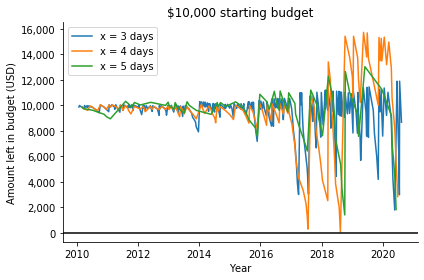

In [9]:
fig, ax = plt.subplots(tight_layout=True)
for key, value in amzn_dict_10k.items():
    ax.plot(amzn_date[value[:,0]], 10000-np.cumsum(amzn_price_np[value[:,0]]*value[:,1]), label=f"x = {key} days")
ax.axhline(0, color="black")
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel("Year")
ax.set_ylabel("Amount left in budget (USD)")
ax.set_title("$10,000 starting budget")
ax.legend(loc="upper left")
sns.despine(fig=fig)

Before 2017, the budget was not fully utilized because the stock price was low, and the strategy never buys more than 1 share at a time. Therefore, **the number of shares to buy at any given time should depend on how much money the budgest still has left.**

Second, can be the buy/sell decision be improved? Let's look at the transactions of x = 4 days (because it has the highest ROI).

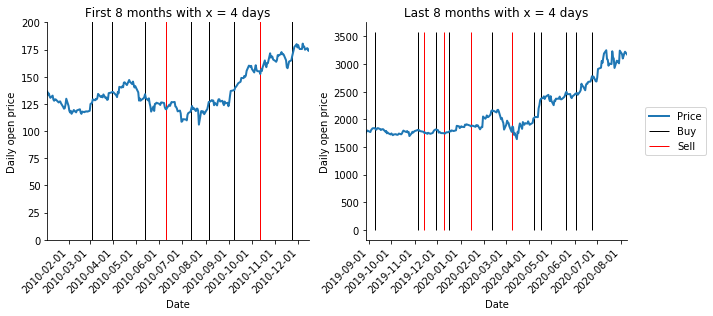

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4.5), tight_layout=True)
# All transactions
ax[0].plot(amzn_date, amzn_price_np, lw=2, label="Price")
ax[0].vlines(amzn_date[amzn_dict_10k[4][amzn_dict_10k[4][:,1]>0,0]],
             0, amzn_price_np.max()*1.1, lw=1, label="Buy")
ax[0].vlines(amzn_date[amzn_dict_10k[4][amzn_dict_10k[4][:,1]<0,0]],
             0, amzn_price_np.max()*1.1, lw=1, color='red', label="Sell")
ax[0].set_xlim(amzn_date[0],amzn_date[240])
ax[0].set_ylim(0,200)
ax[0].set_xticklabels([datetime.fromordinal(int(s)).date() for s in ax[0].get_xticks()], rotation=45, ha='right')
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Daily open price")
ax[0].set_title("First 8 months with x = 4 days")

# Last 120 days
ax[1].plot(amzn_date, amzn_price_np, lw=2, label="Price")
ax[1].vlines(amzn_date[amzn_dict_10k[4][amzn_dict_10k[4][:,1]>0,0]],
             0, amzn_price_np.max()*1.1, lw=1, label="Buy")
ax[1].vlines(amzn_date[amzn_dict_10k[4][amzn_dict_10k[4][:,1]<0,0]],
             0, amzn_price_np.max()*1.1, lw=1, color='red', label="Sell")
ax[1].set_xlim(amzn_date[-240],amzn_date[-1])
ax[1].set_xticklabels([datetime.fromordinal(int(s)).date() for s in ax[1].get_xticks()], rotation=45, ha='right')
ax[1].legend(bbox_to_anchor=(1.05,0.5), loc="center left")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Daily open price")
ax[1].set_title("Last 8 months with x = 4 days")
sns.despine(fig=fig)

It is obvious that sometimes shares are sold at a price lower than it was most recently bought. Therefore, **the sell decision should also take into account the price of previously bought shares.**

Third, recall the argument for this trading strategy about the local minima representing the a drop in stock price. I observe that there are many times when a few local minima are very close to each other. The gaps between two consecutive local minima can be as low as two days, as shown below.

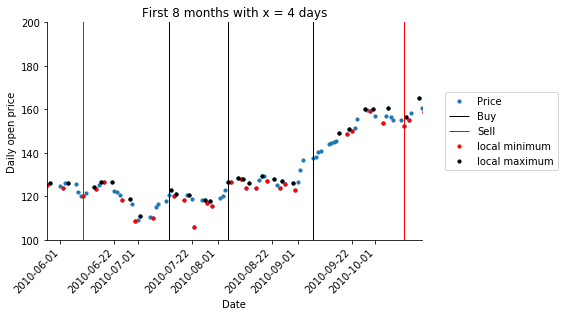

In [11]:
fig, ax = plt.subplots(figsize=(8,4.5), tight_layout=True)
ax.scatter(amzn_date, amzn_price_np, s=10, label="Price")
ax.vlines(amzn_date[amzn_dict_10k[4][amzn_dict_10k[4][:,1]>0,0]],
          0, amzn_price_np.max()*1.1, lw=1, label="Buy")
ax.vlines(amzn_date[amzn_dict_10k[4][amzn_dict_10k[4][:,1]<0,0]],
          0, amzn_price_np.max()*1.1, lw=1, color='red', label="Sell")
minima = signal.argrelmin(amzn_price_np)[0]
maxima = signal.argrelmax(amzn_price_np)[0]
ax.scatter(amzn_date[minima], amzn_price_np[minima], color='red', s=10, label="local minimum")
ax.scatter(amzn_date[maxima], amzn_price_np[maxima], color='black', s=10, label="local maximum")
ax.set_xlim(amzn_date[100],amzn_date[200])
ax.set_ylim(100,200)
ax.set_xticklabels([datetime.fromordinal(int(s)).date() for s in ax.get_xticks()], rotation=45, ha='right')
ax.set_xlabel("Date")
ax.set_ylabel("Daily open price")
ax.set_title("First 8 months with x = 4 days")
ax.legend(bbox_to_anchor=(1.05,0.5), loc="center left")
sns.despine(fig=fig)

Hence, **the buy decision should also look at the time of previous local minima, so that it can be executed earlier at a lower stock price.**

## Trading strategy 2

In summary, I will make three improvements to strategy 1 to arrive at strategy 2:
* If the budget allows for buying more than 1 shares, a portion of the remaining budget will be used to buy as many shares as possible.
* The selling price should be higher than the buying price of currently owned shares.
* The buy decision should also look at the time of previous local minima, so that it can be executed earlier at a lower stock price.

In [12]:
def trading_strat2(price, min_x=1, max_x=5, fees=0, buy_budget=1/3, budget=None):
    '''
    This function will implement trading strategy 2.
    
    A number of shares are bought when stock price has increased consecutively for x days after the last local minimum.
    If the budget can afford more than 1 share, use a portion of the remaining budget (specified by buy_budget) to buy as many
    shares as possible.
    If there are more than one local minima in a window of x days preceding the latest local minimum, then the buy decision
    is executed at x days after the earliest local minimum within that window.
    
    All currently owned shares are sold when stock price has decreased consecutively for x days after the last local maximum.
    In addition, the selling price must be higher than the maximum buying price of currently owned shares.
    
    Input:
    ----------
    price: numpy array
        An 1D numpy array containing the daily stock price.
    min_x: int
        The minimum number of days to test the trading strategy.
        Default is 1.
    max_x: int
        The maximum number of days to test the trading strategy.
        Default is 5.
    fees: float
        The brokerage fees per transaction.
        Default is 0.
    buy_budget: float (>0 and <=1)
        When a buy decision takes place, this buy_budget ratio multiplied by the remaining budget is to be used to buy as many
        shares as possible.
        Default is 1/3.
    budget: int or None
        The budget of the trader. If int, then the trade can only buy stocks if he has enough money left. If None, assume
        the trader has infinite amount of money.
        Default is None.
        
    Output:
    ----------
    A dictionary of transaction history
    The keys indicate value of x.
    The values are numpy arrays of shape (number of transactions, 2)
    First column is the index of price array at which a transaction occurs
    Second column indicates whether the transaction is buying (denoted by +1, ie buying one share) or selling (denoted by -n,
    ie, selling all n shares)
    '''
    
    if budget is None:
        budget = np.inf
    
    out_dict = {}
    
    # Find indices of all local minima and maxima
    minima = signal.argrelmin(price)[0]
    maxima = signal.argrelmax(price)[0]
    
    # Combine the indices and sort
    # The local minima and maxima will be alternating
    combine = np.sort(np.hstack([minima, maxima]))
    
    # Find the gap between a pair of adjacent minimum and maximum
    combine_gap = np.diff(combine)
    
    # Convert the minima and maxima arrays into sets for faster 'in' operator later on
    minima_set = set(minima)
    maxima_set = set(maxima)
    
    # Loop through each value of x to be tested
    for x in range(min_x, max_x+1):
        temp_budget = budget # reset the current budget
        n_shares = 0 # track the number of shares currently own
        trade_index = [] # track the index when transaction occurs
        trade_info = [] # track the number of shares bought or sold
        max_buy_price = 0 # track the maximum buying price of owned shares
        
        # Go through gaps that are at least x-days long
        for i in combine[np.where(combine_gap >= x)]:   
            # Buy decision
            if (i in minima_set):
                # Find the number of local minima within a window of (x-1) days before this local minimum
                # Use (x-1) because a buy decision cannot practically occur at a local minimum
                temp_n_minima = np.sum((minima >= (i-(x-1))) & (minima <= i))
                if temp_n_minima == 1:
                    buy_i = i + x # the index at which the buy decision occurs
                else:
                    buy_i = min(minima[minima >= (i-(x-1))]) + x
                
                # Check if enough budget is left to buy more than 1 share
                temp_n_shares_buy = (temp_budget*buy_budget - fees)/price[buy_i]
                if (temp_n_shares_buy >= 1):
                    temp_n_shares_buy = int(temp_n_shares_buy)
                elif (temp_budget >= price[buy_i] + fees):
                    temp_n_shares_buy = 1
                else:
                    continue
                temp_budget = temp_budget - temp_n_shares_buy*price[buy_i] - fees
                n_shares += temp_n_shares_buy
                trade_index.append(buy_i)
                trade_info.append(temp_n_shares_buy)
                
                # Update buying price
                max_buy_price = max([max_buy_price, price[buy_i]])
                
            # Sell decision
            elif (i in maxima_set) and (n_shares > 0):
                if (price[i+x] > max_buy_price):
                    temp_budget = temp_budget + n_shares*price[i+x] - fees
                    trade_index.append(i+x)
                    trade_info.append(-n_shares)
                    n_shares = 0
                    max_buy_price = 0

        # Update dictionary
        out_dict[x] = np.array([trade_index, trade_info]).T
        
    return out_dict

Testing strategy 2 with x = 3, 4, 5 days under a budget of \\$10,000.

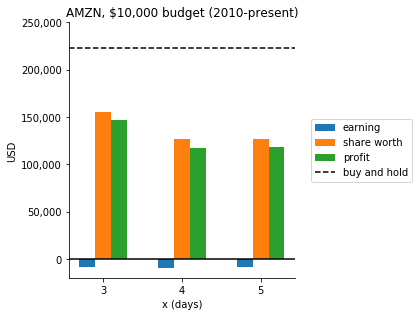

In [13]:
# Test trading strategy 2
amzn_dict2 = trading_strat2(amzn_price_np, min_x=3, budget=10_000)

bar_width = 0.2
fig, ax = plt.subplots(figsize=(6,4.5), tight_layout=True)
for key, value in amzn_dict2.items():
    # Plot earning
    earning = -np.sum(amzn_price_np[value[:,0]]*value[:,1])
    bar1 = ax.bar(key-bar_width, earning, width=bar_width, color=my_colors(0))
    
    # Plot share worth
    share_worth = np.sum(value[:,1])*amzn_price_np[-1]
    bar2 = ax.bar(key, share_worth, width=bar_width, color=my_colors(1))
    
    # Plot profit
    bar3 = ax.bar(key+bar_width, earning+share_worth, width=bar_width, color=my_colors(2))
price0 = amzn_price_np[0]
line1 = ax.axhline((amzn_price_np[-1]-price0)/price0*10000, color='black', ls='--')
ax.axhline(0,color='black')
ax.set_ylim(-20e3, 250e3)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xticks(list(amzn_dict2.keys()))
ax.set_xlabel("x (days)")
ax.set_ylabel("USD")
ax.set_title("AMZN, $10,000 budget (2010-present)")
ax.legend([bar1, bar2, bar3, line1], ["earning","share worth","profit","buy and hold"],
          bbox_to_anchor=(1.05,0.5), loc="center left")
sns.despine(fig=fig)

The profits now look much better than before, thanks largely to the high price of Amazon stock at the moment. Interestingly, x = 3 days has higher profit than the x = 4 and x = 5 days. Budget usage should now be more efficient, especially earlier when the budget is high and the stock price low. However, the strategy still underperforms compared to buying and holding shares for 10 years.

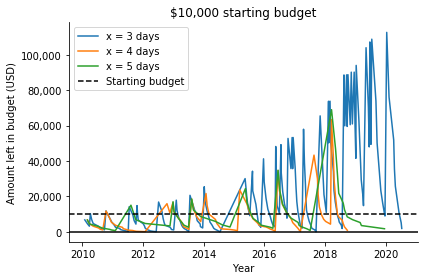

In [14]:
fig, ax = plt.subplots(tight_layout=True)
for key, value in amzn_dict2.items():
    ax.plot(amzn_date[value[:,0]], 10000-np.cumsum(amzn_price_np[value[:,0]]*value[:,1]), label=f"x = {key} days")
ax.axhline(0, color="black")
ax.axhline(10e3, ls="--", label="Starting budget", color="black")
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel("Year")
ax.set_ylabel("Amount left in budget (USD)")
ax.set_title("$10,000 starting budget")
ax.legend(loc="upper left")
sns.despine(fig=fig)

It seems for strategy 2, a selling decision is very conservative, because the profits come mainly from share worth. The transaction history during the final two years shows this.

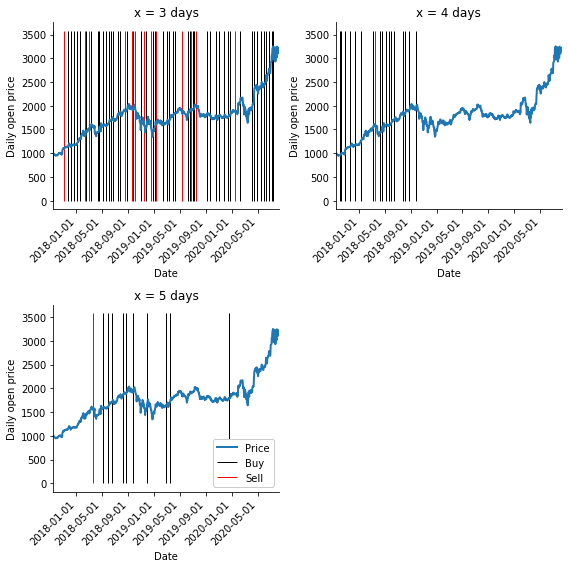

In [15]:
# Plot transaction history
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8), tight_layout=True)
for counter, key in enumerate(amzn_dict2.keys()):
    irow = int(counter/2)
    icol = int(counter % 2)
    ax[irow, icol].plot(amzn_date, amzn_price_np, lw=2, label="Price")
    ax[irow, icol].vlines(amzn_date[amzn_dict2[key][amzn_dict2[key][:,1]>0,0]],
                          0, amzn_price_np.max()*1.1, lw=1, label="Buy")
    ax[irow, icol].vlines(amzn_date[amzn_dict2[key][amzn_dict2[key][:,1]<0,0]],
                          0, amzn_price_np.max()*1.1, lw=1, color='red', label="Sell")
    ax[irow, icol].set_title(f"x = {key} days")
    ax[irow, icol].set_xlim(amzn_date[-2*365],amzn_date[-1])
    ax[irow, icol].set_xticklabels([datetime.fromordinal(int(s)).date() for s in ax[irow, icol].get_xticks()],
                                   rotation=45, ha='right')
    ax[irow, icol].set_xlabel("Date")
    ax[irow, icol].set_ylabel("Daily open price")
ax[1,0].legend(loc="lower right", framealpha=1)
fig.delaxes(ax[1,1])
sns.despine(fig=fig)

It is also clear that many buy decisions occur when the share price is increasing steadily, which is not an intention of the trading strategy. This also disallows selling, since a sell decision checks for the buying price of currently owned shares, which is ever increasing.

To find a suitable check against this situation, I will first look at the period leading to 9/2018 for x = 4 days.

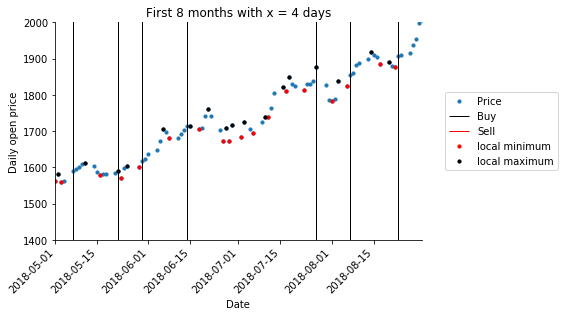

In [16]:
plot_date = amzn_date[(amzn_price.index >= datetime.fromisoformat("2018-05-01")) &
                      (amzn_price.index <= datetime.fromisoformat("2018-09-01"))]
fig, ax = plt.subplots(figsize=(8,4.5), tight_layout=True)
ax.scatter(amzn_date, amzn_price_np, s=10, label="Price")
ax.vlines(amzn_date[amzn_dict2[4][amzn_dict2[4][:,1]>0,0]],
          0, amzn_price_np.max()*1.1, lw=1, label="Buy")
ax.vlines(amzn_date[amzn_dict2[4][amzn_dict2[4][:,1]<0,0]],
          0, amzn_price_np.max()*1.1, lw=1, color='red', label="Sell")
minima = signal.argrelmin(amzn_price_np)[0]
maxima = signal.argrelmax(amzn_price_np)[0]
ax.scatter(amzn_date[minima], amzn_price_np[minima], color='red', s=10, label="local minimum")
ax.scatter(amzn_date[maxima], amzn_price_np[maxima], color='black', s=10, label="local maximum")
ax.set_xlim(plot_date[0], plot_date[-1])
ax.set_ylim(1400,2000)
ax.set_xticklabels([datetime.fromordinal(int(s)).date() for s in ax.get_xticks()], rotation=45, ha='right')
ax.set_xlabel("Date")
ax.set_ylabel("Daily open price")
ax.set_title("First 8 months with x = 4 days")
ax.legend(bbox_to_anchor=(1.05,0.5), loc="center left")
sns.despine(fig=fig)

Upon closer inspection, the buy decisions did occur after a drop in price as intended by the trading strategy 2. Noteably, a buy decision should've occured between 1-15 in 7/2018. This is an artifact of the algorithm: it cheats by only looking at local minima/maxima that are more than x days from the next local maximum/minimum. A more realistic implementation of the strategy will be **deciding a buy or sell decision at each and every day.**

I will now test this strategy 2 on a not-so-strong stock, United Airlines, which has been hit very hard by COVID-19.

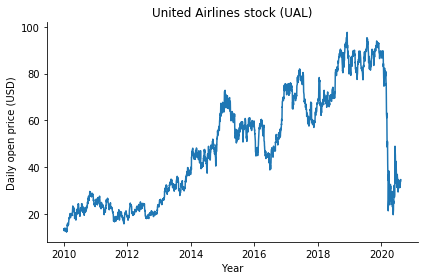

In [17]:
# Import United Airlines share
ual = yf.Ticker("UAL")
ual_price = ual.history(start="2010-01-01")
ual_price_np = ual_price["Open"].to_numpy()
ual_date = ual_price.index.to_numpy()

# Plot stock price
fig, ax = plt.subplots(tight_layout=True)
ax.plot(ual_price["Open"])
ax.set_xlabel("Year")
ax.set_ylabel("Daily open price (USD)")
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title("United Airlines stock (UAL)")
sns.despine(fig=fig)

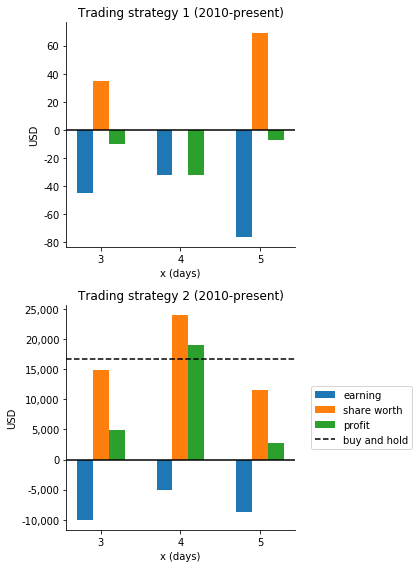

In [18]:
# Test strategy 1 and 2
ual_dict_strat1 = trading_strat1(ual_price_np, min_x=3, budget=10_000)
ual_dict_strat2 = trading_strat2(ual_price_np, min_x=3, budget=10_000)

# Plot profits
bar_width = 0.2
fig, ax = plt.subplots(nrows=2, figsize=(6,8), tight_layout=True)
for i, j in enumerate([ual_dict_strat1,ual_dict_strat2]):
    for key, value in j.items():
        # Plot earning
        earning = -np.sum(ual_price_np[value[:,0]]*value[:,1])
        bar1 = ax[i].bar(key-bar_width, earning, width=bar_width, color=my_colors(0))

        # Plot share worth
        share_worth = np.sum(value[:,1])*ual_price_np[-1]
        bar2 = ax[i].bar(key, share_worth, width=bar_width, color=my_colors(1))

        # Plot profit
        bar3 = ax[i].bar(key+bar_width, earning+share_worth, width=bar_width, color=my_colors(2))
    ax[i].axhline(0,color='black')
    ax[i].get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    ax[i].set_xticks(list(j.keys()))
    ax[i].set_xlabel("x (days)")
    ax[i].set_ylabel("USD")
    ax[i].set_title(f"Trading strategy {i+1} (2010-present)")
price0 = ual_price_np[0]
line1 = ax[1].axhline((ual_price_np[-1]-price0)/price0*10000, color='black', ls='--')
ax[1].legend([bar1, bar2, bar3, line1], ["earning","share worth","profit","buy and hold"],
             bbox_to_anchor=(1.05,0.5), loc="center left")
sns.despine(fig=fig)

Trading strategy 2 again outperforms strategy 1 by a significant margin. Surprisingly, it outperforms buy and hold strategy with x = 4 days.

To understand the large discrepancy between x = 4 and x = 3 or 5 days, I will first look at the budget utilization.

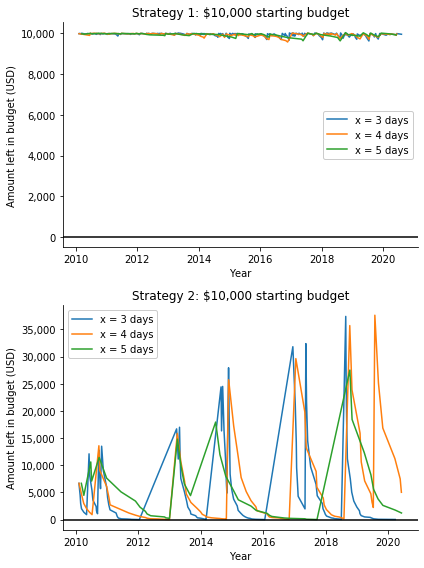

In [19]:
fig, ax = plt.subplots(nrows=2, figsize=(6,8), tight_layout=True)
for i, j in enumerate([ual_dict_strat1,ual_dict_strat2]):
    for key, value in j.items():
        ax[i].plot(ual_date[value[:,0]], 10000-np.cumsum(ual_price_np[value[:,0]]*value[:,1]), label=f"x = {key} days")
    ax[i].axhline(0, color="black")
    ax[i].get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    ax[i].set_xlabel("Year")
    ax[i].set_ylabel("Amount left in budget (USD)")
    ax[i].set_title(f"Strategy {i+1}: $10,000 starting budget")
    ax[i].legend(loc="best", framealpha=1)
sns.despine(fig=fig)

The low profit of strategy 1 is most likely because each buy decision only buys one share. Furthermore, for strategy 2, the budget of x = 4 days reached above \\$35,000 close to 2020, but the share worth at the end is lower than \\$25,000, suggesting that there was a large drop in stock price, and that the strategy did not sell during the drop. This resulted in about \\$10,000 reduction in profit. This is shown below as I inspect the transaction history of strategy 2 during the 2 years.

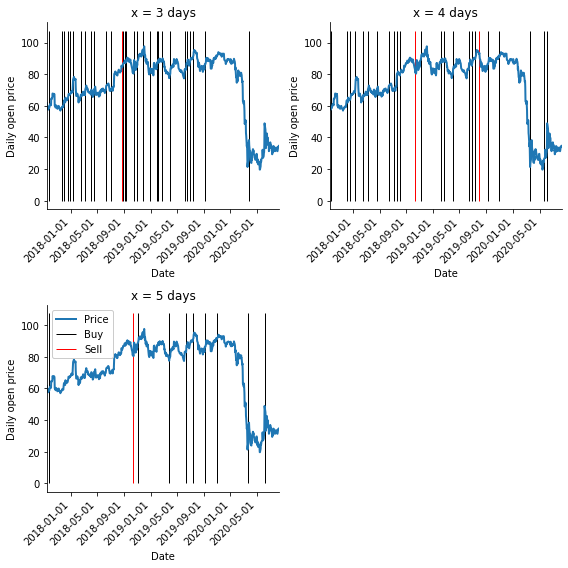

In [20]:
# Plot transaction history
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8), tight_layout=True)
for counter, key in enumerate(ual_dict_strat2.keys()):
    irow = int(counter/2)
    icol = int(counter % 2)
    ax[irow, icol].plot(ual_date, ual_price_np, lw=2, label="Price")
    ax[irow, icol].vlines(ual_date[ual_dict_strat2[key][ual_dict_strat2[key][:,1]>0,0]],
                          0, ual_price_np.max()*1.1, lw=1, label="Buy")
    ax[irow, icol].vlines(ual_date[ual_dict_strat2[key][ual_dict_strat2[key][:,1]<0,0]],
                          0, ual_price_np.max()*1.1, lw=1, color='red', label="Sell")
    ax[irow, icol].set_title(f"x = {key} days")
    ax[irow, icol].set_xlim(ual_date[-2*365], ual_date[-1])
#     ax[irow, icol].set_ylim(0, 500)
    ax[irow, icol].set_xticklabels([datetime.fromordinal(int(s)).date() for s in ax[irow, icol].get_xticks()],
                                   rotation=45, ha='right')
    ax[irow, icol].set_xlabel("Date")
    ax[irow, icol].set_ylabel("Daily open price")
ax[1,0].legend(loc="best", framealpha=1)
fig.delaxes(ax[1,1])
sns.despine(fig=fig)

It is likely that the better performance of x = 4 days is due to it executing a sell decision around August 2019, thus recovering the loss that would have occured because of the crash early 2020. This is because the selling price was never above the buying price during the crash. **Therefore, I will need to add a check for stock crashing.**

A crash is different from a decline, and to implement a crash check that best suits the trading strategy, let's look at the crash between 1/2020 and now.

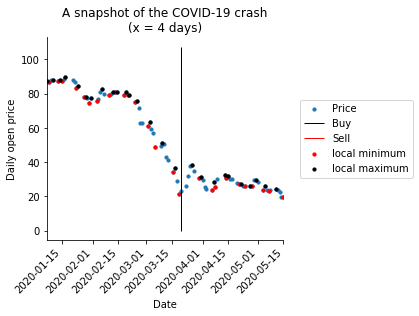

In [21]:
fig, ax = plt.subplots(figsize=(6,4.5), tight_layout=True)
ax.scatter(ual_date, ual_price_np, s=10, label="Price")
ax.vlines(ual_date[ual_dict_strat2[4][ual_dict_strat2[4][:,1]>0,0]],
          0, ual_price_np.max()*1.1, lw=1, label="Buy")
ax.vlines(ual_date[ual_dict_strat2[4][ual_dict_strat2[4][:,1]<0,0]],
          0, ual_price_np.max()*1.1, lw=1, color='red', label="Sell")
minima = signal.argrelmin(ual_price_np)[0]
maxima = signal.argrelmax(ual_price_np)[0]
ax.scatter(ual_date[minima], ual_price_np[minima], color='red', s=10, label="local minimum")
ax.scatter(ual_date[maxima], ual_price_np[maxima], color='black', s=10, label="local maximum")
ax.set_xlim(ual_date[-150], ual_date[-60])
ax.set_xticklabels([datetime.fromordinal(int(s)).date() for s in ax.get_xticks()], rotation=45, ha='right')
ax.set_xlabel("Date")
ax.set_ylabel("Daily open price")
ax.legend(bbox_to_anchor=(1.05,0.5), loc="center left")
ax.set_title("A snapshot of the COVID-19 crash\n(x = 4 days)")
sns.despine(fig=fig)

During the crash, the local minima continuously decreased by a large percentage. While the crash check can check for these two conditions, the sell decision might not be executed fast enough if there are multiple days in-between these local minima. Therefore, I shall implement a loss check, where **a sell decision is executed if a certain amount of loss will be realized if all currently owned shares are sold.**

## Trading strategy 3
For strategy 3, the following improvements are made to strategy 2:
* The algorithm will now checks for a buy/sell decision at each and every day, using only the price data in the preceding window.
* A sell decision is executed if the capital loss from selling all currently owned shares passes a certain threshold.

In [22]:
def trading_strat3(price, min_x=1, max_x=5, fees=0, buy_budget=1/3, budget=10_000, loss_ratio=0.1):
    '''
    This function will implement trading strategy 3. Now the algorithm will go through each and every day, and check whether
    a buy or sell decision should be executed
    
    A number of shares are bought when stock price has increased consecutively for x days after the last local minimum.
    If the budget can afford more than 1 share, use a portion of the remaining budget (specified by buy_budget) to buy as many
    shares as possible.
    If there are more than one local minima in a window of x days preceding the latest local minimum, then the buy decision
    is executed at x days after the earliest local minimum within that window.
    
    All currently owned shares are sold when stock price has decreased consecutively for x days after the last local maximum.
    The selling price must also be higher than the maximum buying price of currently owned shares. If not, a sell decision will
    occur if the capital loss from selling all currently owned shares reaches the loss_ratio multiply by
    the starting budget or the amount spent on buying the owned shares, whichever is lower.
    
    Input:
    ----------
    price: numpy array
        An 1D numpy array containing the daily stock price.
    min_x: int
        The minimum number of days to test the trading strategy.
        Default is 1.
    max_x: int
        The maximum number of days to test the trading strategy.
        Default is 5.
    fees: float
        The brokerage fees per transaction.
        Default is 0.
    buy_budget: float (>0 and <=1)
        When a buy decision takes place, this buy_budget ratio multiplied by the remaining budget is to be used to buy as many
        shares as possible.
        Default is 1/3.
    budget: int
        The starting budget of the trader.
        Default is $10,000.
    loss_ratio: float (>= 0)
        Sell all shares if selling all currently owned shares at the current price results in a capital loss above
        the loss_ratio multiplied by the starting budget, or the amount spent on buying currently owned shares, whichever is
        lower.
        Default is 0.1.
        
    Output:
    ----------
    A dictionary of transaction history
    The keys indicate value of x.
    The values are numpy arrays of shape (number of transactions, 2)
    First column is the index of price array at which a transaction occurs
    Second column indicates whether the transaction is buying (denoted by +1, ie buying one share) or selling (denoted by -n,
    ie, selling all n shares)
    '''
    
    if budget is None:
        budget = np.inf
    
    out_dict = {}
    
    # Find indices of all local minima and maxima
    minima = signal.argrelmin(price)[0]
    maxima = signal.argrelmax(price)[0]
    
    # Combine the indices and sort
    # The local minima and maxima will be alternating
    combine = np.sort(np.hstack([minima, maxima]))
    
    # Find the gap between a pair of adjacent minimum and maximum
    combine_gap = np.diff(combine)
    
    # Convert the minima and maxima arrays into sets for faster 'in' operator later on
    minima_set = set(minima)
    maxima_set = set(maxima)
    
    # Loop through each value of x to be tested
    for x in range(min_x, max_x+1):
        temp_budget = budget # reset the current budget
        n_shares = 0 # track the number of shares currently own
        trade_index = [] # track the index when transaction occurs
        trade_info = [] # track the number of shares bought or sold
        max_buy_price = 0 # track the maximum buying price of owned shares
        spent_buy = 0 # track the amount of money spent on buying currently owned shares
        
        # Loop through the daily price
        for date_i, price_i in enumerate(price):
            # Skip the first 2 days
            if date_i <= 1:
                continue
                
            price_window = price[(date_i-2*x):(date_i+1)] # a window of 2*x days
            
            # Get local minima and maxima
            minima = signal.argrelmin(price_window)[0] + (date_i-2*x) # indices are w.r.t. start of price array
            maxima = signal.argrelmax(price_window)[0] + (date_i-2*x) # indices are w.r.t. start of price array
            
            # Take into account when no extrema are detected
            if len(minima) == 0:
                minima = np.array([-1])
            if len(maxima) == 0:
                maxima = np.array([-1])
            
            # Check buy decision if the most recent extremum is a minimum
            if (minima[-1] > maxima[-1]):
                # If today is x days after the earliest local minimum within the x-day window, buy shares
                if not any(minima >= (date_i-x)):
                    continue
                if ((minima[np.where(minima >= (date_i-x))][0] + x) == date_i):
                    # Check budget
                    temp_n_shares_buy = (temp_budget*buy_budget - fees)/price_i
                    if (temp_n_shares_buy >= 1):
                        temp_n_shares_buy = int(temp_n_shares_buy)
                    elif (temp_budget >= price_i + fees):
                        temp_n_shares_buy = 1
                    else:
                        continue
                    temp_budget = temp_budget - temp_n_shares_buy*price_i - fees
                    n_shares += temp_n_shares_buy
                    trade_index.append(date_i)
                    trade_info.append(temp_n_shares_buy)
                    
                    # Update buying price and money spent
                    max_buy_price = max([max_buy_price, price_i])
                    spent_buy += temp_n_shares_buy*price_i
                    
            # Check sell decision
            elif (n_shares > 0):
                # Sell if it has been x days since the last maximum, and the selling price is higher than the buying price
                # of currently owned shares
                if (maxima[-1] + x == date_i) and (price_i > max_buy_price):
                    temp_budget = temp_budget + n_shares*price_i - fees
                    trade_index.append(date_i)
                    trade_info.append(-n_shares)
                    n_shares = 0
                    max_buy_price = 0
                    spent_buy = 0
                
                # Sell if capital loss passes a threshold
                elif ((spent_buy - n_shares*price_i) >= loss_ratio*min([spent_buy, budget])):
                    temp_budget = temp_budget + n_shares*price_i - fees
                    trade_index.append(date_i)
                    trade_info.append(-n_shares)
                    n_shares = 0
                    max_buy_price = 0
                    spent_buy = 0

        # Update dictionary
        out_dict[x] = np.array([trade_index, trade_info]).T
        
    return out_dict

Test on AMZN and UAL again with $10,000 starting budget.

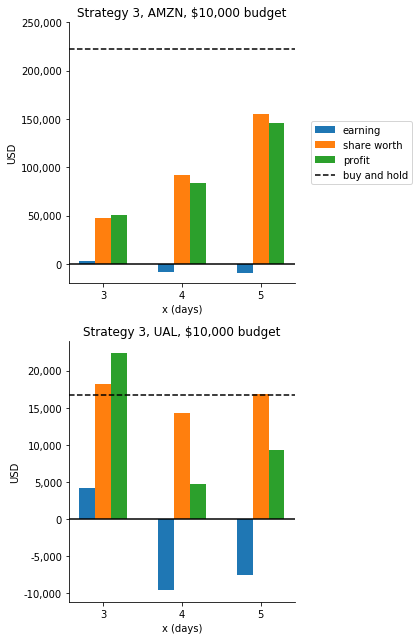

In [23]:
##### AMZN
amzn_dict3 = trading_strat3(amzn_price_np, min_x=3, budget=10_000)
bar_width = 0.2
fig, ax = plt.subplots(nrows=2, figsize=(6,9), tight_layout=True)
for key, value in amzn_dict3.items():
    # Plot earning
    earning = -np.sum(amzn_price_np[value[:,0]]*value[:,1])
    bar1 = ax[0].bar(key-bar_width, earning, width=bar_width, color=my_colors(0))
    
    # Plot share worth
    share_worth = np.sum(value[:,1])*amzn_price_np[-1]
    bar2 = ax[0].bar(key, share_worth, width=bar_width, color=my_colors(1))
    
    # Plot profit
    bar3 = ax[0].bar(key+bar_width, earning+share_worth, width=bar_width, color=my_colors(2))
price0 = amzn_price_np[0]
line1 = ax[0].axhline((amzn_price_np[-1]-price0)/price0*10000, color='black', ls='--')
ax[0].axhline(0, color='black')
ax[0].set_ylim(-20e3, 250e3)
ax[0].get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax[0].set_xticks(list(amzn_dict3.keys()))
ax[0].set_xlabel("x (days)")
ax[0].set_ylabel("USD")
ax[0].legend([bar1, bar2, bar3, line1], ["earning","share worth","profit","buy and hold"],
             bbox_to_anchor=(1.05,0.5), loc="center left")
ax[0].set_title("Strategy 3, AMZN, $10,000 budget")

##### UAL
ual_dict3 = trading_strat3(ual_price_np, min_x=3, budget=10_000)
bar_width = 0.2
for key, value in ual_dict3.items():
    # Plot earning
    earning = -np.sum(ual_price_np[value[:,0]]*value[:,1])
    bar1 = ax[1].bar(key-bar_width, earning, width=bar_width, color=my_colors(0))
    
    # Plot share worth
    share_worth = np.sum(value[:,1])*ual_price_np[-1]
    bar2 = ax[1].bar(key, share_worth, width=bar_width, color=my_colors(1))
    
    # Plot profit
    bar3 = ax[1].bar(key+bar_width, earning+share_worth, width=bar_width, color=my_colors(2))
price0 = ual_price_np[0]
line1 = ax[1].axhline((ual_price_np[-1]-price0)/price0*10000, color='black', ls='--')
ax[1].axhline(0,color='black')
# ax.set_ylim(-20e3, 250e3)
ax[1].get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax[1].set_xticks(list(ual_dict3.keys()))
ax[1].set_xlabel("x (days)")
ax[1].set_ylabel("USD")
ax[1].set_title("Strategy 3, UAL, $10,000 budget")
sns.despine(fig=fig)

Strategy 3 performs equally to strategy 2 for AMZN, and moderately better than strategy 2 for UAL. Strategy 3 still underperforms buy and hold for AMZN, and outperforms for UAL. This time it is x = 3 days that outperforms buy and hold for UAL, instead of x = 4 for strategy 2 above.

It is possible that because stocks history have gone up in price, and therefore buy and hold usually has the best return, espcially for such a strong stock like AMZN. What if we compare the short term profit: stock trading within 1 year.

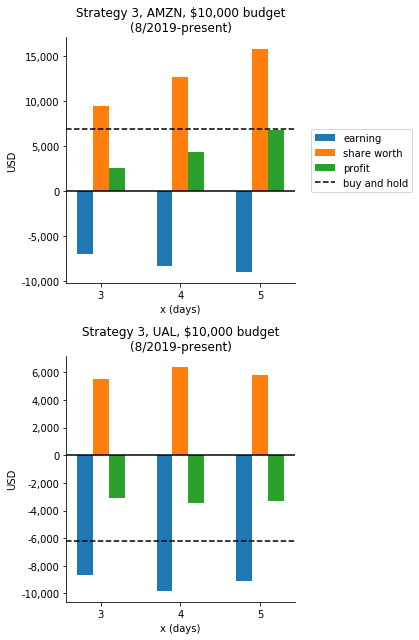

In [24]:
##### AMZN
amzn_period_1year = (amzn_price.index >= datetime.fromisoformat("2019-08-01"))
amzn_dict3 = trading_strat3(amzn_price_np[amzn_period_1year], min_x=3, budget=10_000)
bar_width = 0.2
fig, ax = plt.subplots(nrows=2, figsize=(6,9), tight_layout=True)
for key, value in amzn_dict3.items():
    # Plot earning
    earning = -np.sum(amzn_price_np[amzn_period_1year][value[:,0]]*value[:,1])
    bar1 = ax[0].bar(key-bar_width, earning, width=bar_width, color=my_colors(0))
    
    # Plot share worth
    share_worth = np.sum(value[:,1])*amzn_price_np[-1]
    bar2 = ax[0].bar(key, share_worth, width=bar_width, color=my_colors(1))
    
    # Plot profit
    bar3 = ax[0].bar(key+bar_width, earning+share_worth, width=bar_width, color=my_colors(2))
price0 = amzn_price_np[amzn_period_1year][0]
line1 = ax[0].axhline((amzn_price_np[-1]-price0)/price0*10000, color='black', ls='--')
ax[0].axhline(0, color='black')
# ax[0].set_ylim(-20e3, 250e3)
ax[0].get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax[0].set_xticks(list(amzn_dict3.keys()))
ax[0].set_xlabel("x (days)")
ax[0].set_ylabel("USD")
ax[0].legend([bar1, bar2, bar3, line1], ["earning","share worth","profit","buy and hold"],
             bbox_to_anchor=(1.05,0.5), loc="center left")
ax[0].set_title("Strategy 3, AMZN, $10,000 budget\n(8/2019-present)")

##### UAL
ual_period_1year = (ual_price.index >= datetime.fromisoformat("2019-08-01"))
ual_dict3 = trading_strat3(ual_price_np[ual_period_1year], min_x=3, budget=10_000)
bar_width = 0.2
for key, value in ual_dict3.items():
    # Plot earning
    earning = -np.sum(ual_price_np[ual_period_1year][value[:,0]]*value[:,1])
    bar1 = ax[1].bar(key-bar_width, earning, width=bar_width, color=my_colors(0))
    
    # Plot share worth
    share_worth = np.sum(value[:,1])*ual_price_np[-1]
    bar2 = ax[1].bar(key, share_worth, width=bar_width, color=my_colors(1))
    
    # Plot profit
    bar3 = ax[1].bar(key+bar_width, earning+share_worth, width=bar_width, color=my_colors(2))
price0 = ual_price_np[ual_period_1year][0]
line1 = ax[1].axhline((ual_price_np[-1]-price0)/price0*10000, color='black', ls='--')
ax[1].axhline(0,color='black')
# ax.set_ylim(-20e3, 250e3)
ax[1].get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax[1].set_xticks(list(ual_dict3.keys()))
ax[1].set_xlabel("x (days)")
ax[1].set_ylabel("USD")
ax[1].set_title("Strategy 3, UAL, $10,000 budget\n(8/2019-present)")
sns.despine(fig=fig)

This time, strategy 3 only matches buy and hold for AMZN at x = 5 days. In contrast, strategy 3 outperforms buy and hold for UAL, although it still results in a net loss.

Finally, I will investigate if it is possible for strategy 3 to have a positive net gain with UAL. The plots of the transaction history and budget utilization are shown below.

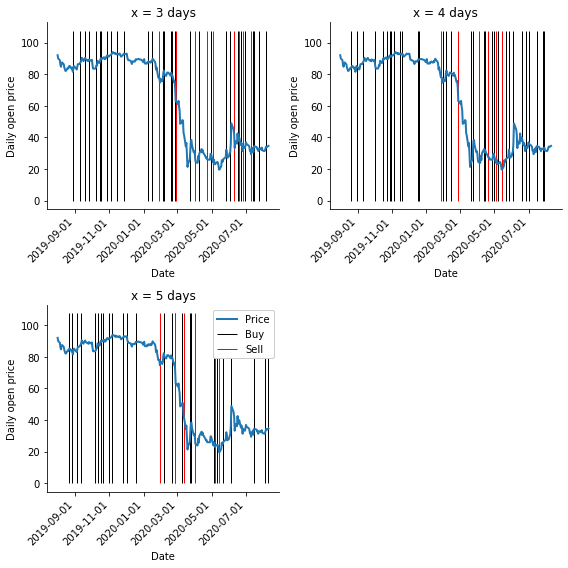

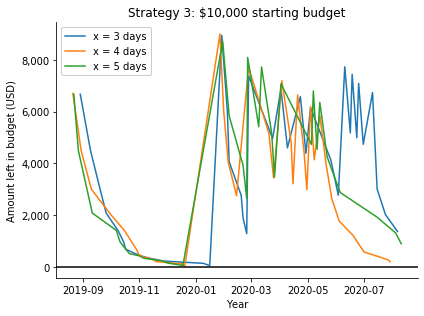

In [25]:
# Plot transaction history
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8), tight_layout=True)
for counter, key in enumerate(ual_dict3.keys()):
    irow = int(counter/2)
    icol = int(counter % 2)
    ax[irow, icol].plot(ual_date[ual_period_1year], ual_price_np[ual_period_1year], lw=2, label="Price")
    ax[irow, icol].vlines(ual_date[ual_period_1year][ual_dict3[key][ual_dict3[key][:,1]>0,0]],
                          0, ual_price_np.max()*1.1, lw=1, label="Buy")
    ax[irow, icol].vlines(ual_date[ual_period_1year][ual_dict3[key][ual_dict3[key][:,1]<0,0]],
                          0, ual_price_np.max()*1.1, lw=1, color='red', label="Sell")
    ax[irow, icol].set_title(f"x = {key} days")
#     ax[irow, icol].set_xlim(ual_date[-2*365], ual_date[-1])
#     ax[irow, icol].set_ylim(0, 500)
    ax[irow, icol].set_xticklabels([datetime.fromordinal(int(s)).date() for s in ax[irow, icol].get_xticks()],
                                   rotation=45, ha='right')
    ax[irow, icol].set_xlabel("Date")
    ax[irow, icol].set_ylabel("Daily open price")
ax[1,0].legend(loc="best", framealpha=1)
fig.delaxes(ax[1,1])
sns.despine(fig=fig)

# Plot budget utilization
fig, ax = plt.subplots(figsize=(6,4.5), tight_layout=True)
for key, value in ual_dict3.items():
    ax.plot(ual_date[ual_period_1year][value[:,0]],
            10000-np.cumsum(ual_price_np[ual_period_1year][value[:,0]]*value[:,1]),
            label=f"x = {key} days")
ax.axhline(0, color="black")
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel("Year")
ax.set_ylabel("Amount left in budget (USD)")
ax.set_title("Strategy 3: $10,000 starting budget")
ax.legend(loc="best", framealpha=1)
sns.despine(fig=fig)

From the share price of UAL, it is clear that my strategy is not able to return a profit, because the stock price never recover after the crash. During the last quarter of 2019, many buy decisions were executed, and the cost never recovered from subsequent selling. Fortunately, the selling check was executed to minize the amount loss.

Finally, I will compare strategy 2 and 3 for the same period of 8/2019-present.

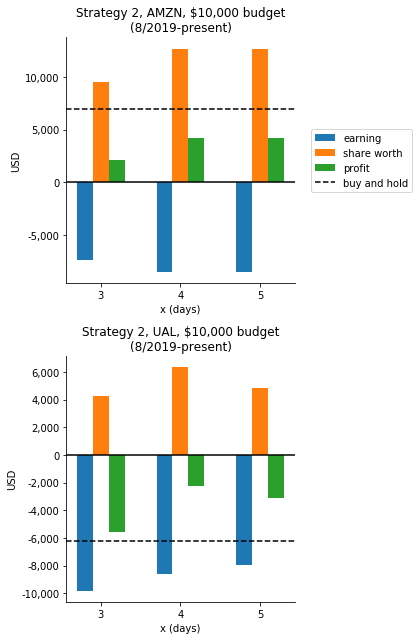

In [26]:
##### AMZN
amzn_period_1year = (amzn_price.index >= datetime.fromisoformat("2019-08-01"))
amzn_dict2 = trading_strat2(amzn_price_np[amzn_period_1year], min_x=3, budget=10_000)
bar_width = 0.2
fig, ax = plt.subplots(nrows=2, figsize=(6,9), tight_layout=True)
for key, value in amzn_dict2.items():
    # Plot earning
    earning = -np.sum(amzn_price_np[amzn_period_1year][value[:,0]]*value[:,1])
    bar1 = ax[0].bar(key-bar_width, earning, width=bar_width, color=my_colors(0))
    
    # Plot share worth
    share_worth = np.sum(value[:,1])*amzn_price_np[-1]
    bar2 = ax[0].bar(key, share_worth, width=bar_width, color=my_colors(1))
    
    # Plot profit
    bar3 = ax[0].bar(key+bar_width, earning+share_worth, width=bar_width, color=my_colors(2))
price0 = amzn_price_np[amzn_period_1year][0]
line1 = ax[0].axhline((amzn_price_np[-1]-price0)/price0*10000, color='black', ls='--')
ax[0].axhline(0, color='black')
# ax[0].set_ylim(-20e3, 250e3)
ax[0].get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax[0].set_xticks(list(amzn_dict2.keys()))
ax[0].set_xlabel("x (days)")
ax[0].set_ylabel("USD")
ax[0].legend([bar1, bar2, bar3, line1], ["earning","share worth","profit","buy and hold"],
             bbox_to_anchor=(1.05,0.5), loc="center left")
ax[0].set_title("Strategy 2, AMZN, $10,000 budget\n(8/2019-present)")

##### UAL
ual_period_1year = (ual_price.index >= datetime.fromisoformat("2019-08-01"))
ual_dict2 = trading_strat2(ual_price_np[ual_period_1year], min_x=3, budget=10_000)
bar_width = 0.2
for key, value in ual_dict2.items():
    # Plot earning
    earning = -np.sum(ual_price_np[ual_period_1year][value[:,0]]*value[:,1])
    bar1 = ax[1].bar(key-bar_width, earning, width=bar_width, color=my_colors(0))
    
    # Plot share worth
    share_worth = np.sum(value[:,1])*ual_price_np[-1]
    bar2 = ax[1].bar(key, share_worth, width=bar_width, color=my_colors(1))
    
    # Plot profit
    bar3 = ax[1].bar(key+bar_width, earning+share_worth, width=bar_width, color=my_colors(2))
price0 = ual_price_np[ual_period_1year][0]
line1 = ax[1].axhline((ual_price_np[-1]-price0)/price0*10000, color='black', ls='--')
ax[1].axhline(0,color='black')
# ax.set_ylim(-20e3, 250e3)
ax[1].get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax[1].set_xticks(list(ual_dict2.keys()))
ax[1].set_xlabel("x (days)")
ax[1].set_ylabel("USD")
ax[1].set_title("Strategy 2, UAL, $10,000 budget\n(8/2019-present)")
sns.despine(fig=fig)

The performance of strategy 2 is in general worse than strategy 3. First, strategy 2 never passes $5,000 profit for AMZN, while strategy 3 does with x = 5 days. Second, for UAL, strategy 2's loss with x = 3 days is much higher than any tested values of x for strategy 3. Therefore, without knowing an optimal value of x beforehand, strategy 3 is safer thanks to the added check for minimizing loss.

## Conclusion

In short, my simple trading strategy usually underperform buy and hold, especially for a long period. This is probably expected, given the common wisdom that one cannot reliably beat the market. Furthermore, my strategy does not rely on other market information that a stock trader would normally need. However, I did manage to improve my trading strategy through the 3 versions.